# 0. Initialize

In [1]:
import gym 

import torch
import torch.nn.functional as F #needed for activation functions
import torch.optim as opt #needed for optimisation
import random
import numpy as np

import matplotlib.pyplot as plt

from torch import nn #needed for building neural networks
from copy import copy, deepcopy
from collections import deque

print("Using torch version: {}".format(torch.__version__))

Using torch version: 1.5.1+cpu


# 1. 환경 불러오기 (Gym-Pendulum )

In [2]:
env_name = "Pendulum-v0"
env = gym.make(env_name)

### 환경의 state / action_dimension을 체크
- Network 의 input dimension과 output dimension을 결정하기 위함

In [3]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

action space의 boundary 체크

In [4]:
action_low = env.action_space.low
action_high = env.action_space.high

In [5]:
action_low, action_high

(array([-2.], dtype=float32), array([2.], dtype=float32))

# 1-1. Main running code with random action

In [6]:
initial_state = env.reset()
  
while True:
    env.render()
    action =  np.random.uniform(low=action_low, high=action_high)
    state_next, reward, done, info = env.step(action)

    if done:
        break
env.close()

__Note__: pendulum 환경은 rendering이 있지만 우리가 사용할 환경에는 render option이 없습니다!

# 2. Agent를 만들 준비를 해볼까요?


## 2-1. Actor Network
__Actor__ : state를 기반으로 action을 만들어주는 네트워크
- input dim : dimension of state
- output dim : dimension of action

__Note__ : Actor 의 output activation은 tanh 로 사용. 

&nbsp;&nbsp;&nbsp; $\because a_t\in [-1,1]$ 으로 만들어 주기 위함

### Tanh function as an activation function 

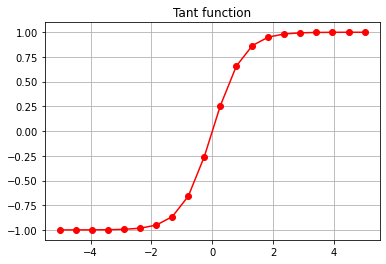

In [7]:
x = np.linspace(-5, 5, 20)
y = np.tanh(x)
plt.plot(x, y, color='red', marker="o")
plt.title("Tant function") 
plt.grid()
plt.show()

In [8]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=[64, 64]):
        super(Actor, self).__init__()
        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()

        input_dims = [state_dim] + hidden_dim
        output_dims = hidden_dim + [action_dim]

        for in_dim, out_dim in zip(input_dims, output_dims):
            self.layers.append(nn.Linear(in_dim, out_dim))

        for i in range(len(hidden_dim)):
            self.activations.append(nn.LeakyReLU())

        self.activations.append(nn.Tanh())

    def forward(self, state):
        x = state
        for l, activation in zip(self.layers, self.activations):
            x = l(x)
            x = activation(x)
        return x

## 2-2. Critic Network

__Critic__ : state와 action을 기반으로 가치를 평가해주는 네트워크
- input dim : dimension of state + dimension of action
- output dim : 1

&nbsp;&nbsp; __Note__ : Critic 의 output activation은 None / Identity 로 사용. 

&nbsp;&nbsp;&nbsp; $\because Q(s_t,a_t)\in [-\inf,\inf]$ 으로 만들어 주기 위함

In [9]:
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=[64, 64], output_dim=1):
        super(Critic, self).__init__()
        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()

        input_dims = [state_dim + action_dim] + hidden_dim
        output_dims = hidden_dim + [output_dim]

        for in_dim, out_dim in zip(input_dims, output_dims):
            self.layers.append(nn.Linear(in_dim, out_dim))

        for i in range(len(hidden_dim)):
            self.activations.append(nn.LeakyReLU())

        self.activations.append(nn.Identity())

    def forward(self, state, action):
        x = torch.cat([state, action], dim=-1)
        for l, act in zip(self.layers, self.activations):
            x = l(x)
            x = act(x)

        return x

## 2-3  Target Network 

## Target Network를 두는 이유와 update 하는 방법에 대한 수식 추가##



In [10]:
def update_model(source, target, tau):
    for src_param, target_param in zip(source.parameters(), target.parameters()):
        target_param.data.copy_(tau * src_param.data + (1.0 - tau) * target_param.data)

## 2-4 Replay Memory

__Replay Memory__: state transition:  $(s, a, r, s', terminal)$ 을 저장하는 공간

Replay memory에 포함되어야 하는 함수들

__1. push__
* input: $[s, a, r, s', terminal]$

    memory에 sample로 이루어진 list를 추가하는 함수
   

__2. sample__
* input: sample size

memory에 쌓인 transition들을 __sample size__ 만큼 sampling하는 함수

In [11]:
class ReplayMemory:
    def __init__(self, length):
        self.memory = deque(maxlen=length)

    def __len__(self):
        return len(self.memory)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, size):
        sample = random.sample(self.memory, size)

        state = [i[0] for i in sample]
        action = [i[1] for i in sample]
        reward = [i[2] for i in sample]
        next_state = [i[3] for i in sample]
        terminal = [i[4] for i in sample]

        state = np.stack(state)
        state = torch.Tensor(state).squeeze()

        next_state = np.stack(next_state)
        next_state = torch.Tensor(next_state).squeeze()

        reward = np.array(reward)
        reward = torch.tensor(reward, dtype=torch.float32).reshape(-1, 1)

        terminal = np.array(terminal).astype(int)
        terminal = torch.tensor(terminal).reshape(-1, 1)

        action = np.array(action)
        action = torch.tensor(action, dtype=torch.float32)

        return state, action, reward, next_state, terminal

## 2-5 Ornstein–Uhlenbeck process

- 시간에 따라 correlated 되어 있으며, 평균으로 회귀하는 random process
- 추후 OU noise를 통해서 exploration을 진행

__OU process__

 <div align="center"> $dx_t = \theta(\mu-x_t)dt + \sigma dW_t$ </div>


* $\theta$ 는 평균 $\mu $로 얼마나 빠르게 회귀할지를 결정하는 parameter
* $\sigma$ 는 process의 randomness를 나타내는 parameter
* $W_t$ Weiner process


__Build OU process__

In [12]:
class OUNoise:
    """
    Taken from https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py
    """

    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=1000):
        self.mu = mu
        self.theta = theta
        self.sigma = max_sigma
        self.max_sigma = max_sigma
        self.min_sigma = min_sigma
        self.decay_period = decay_period
        self.action_dim = action_space
        self.reset()

        self.epsilon = 1.0
        self.epsilon_decay = 0.00001
        self.epsilon_min = 0.05

    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu

    def evolve_state(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state

    def get_action(self, action, t=0):
        ou_state = self.evolve_state() * self.epsilon

        self.epsilon -= self.epsilon_decay
        if self.epsilon < self.epsilon_min:
            self.epsilon = self.epsilon_min

        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, -1.0, 1.0)

#### 만들어진 OU noise 함수를 테스트해볼까요?

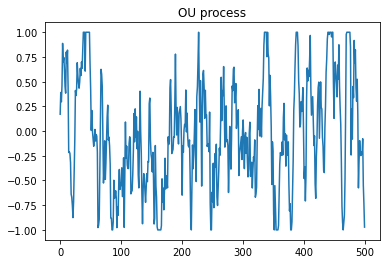

In [13]:
sample_ou_noise = OUNoise(1)
sample_ou_noise.reset()

out = []
for _ in range(500):
    out.append(sample_ou_noise.get_action(0))
    
plt.plot(out)
plt.title('OU process')
plt.show()

## 3. Let's build agent!

### Agent 에 포함되어야 하는 함수들
#### 1. get_action
* input: state
* output: action

    state를 받아서 actor을 통과시켜 action을 return하는 함수
    
#### 2. save_transition
* input: (s, a, r, s', terminal)

    memory에 transition을 저장하는 함수
    
#### 3. train_start
* output: True or False

    memory size가 batch size보다 커서 학습을 시작할 수 있는지 체크하는 함수

#### 4. fit
* output : critic loss, actor loss

    actor와 critic을 학습하는 함수

In [14]:
class DDPGAgent(nn.Module):
    def __init__(self, state_dim, action_dim, action_min, action_max, gamma=0.99):
        super(DDPGAgent, self).__init__()
        self.action_min = np.array(action_min)
        self.action_max = np.array(action_max)

        self.gamma = gamma
        self.ou_noise = OUNoise(action_dim)

        self.actor = Actor(state_dim, action_dim)
        self.critic = Critic(state_dim, action_dim)

        self.actor_target = Actor(state_dim, action_dim)
        self.critic_target = Critic(state_dim, action_dim)

        update_model(self.actor, self.actor_target, tau=1.0)
        update_model(self.critic, self.critic_target, tau=1.0)

        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=1e-4)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=1e-3)

        self.memory = ReplayMemory(5000)
        self.batch_size = 50
        self.tau = 0.005

        self.loss_ftn = nn.MSELoss()

    def get_action(self, state, t=0):
        action_before_norm = self.actor(state).detach().numpy()
        action_before_norm = self.ou_noise.get_action(action_before_norm, t)

        action_after_norm = (action_before_norm + 1) / 2 * (self.action_max - self.action_min) + self.action_min

        return action_before_norm, action_after_norm

    def push(self, transition):
        self.memory.push(transition)

    def train_start(self):
        return len(self.memory) > self.batch_size

    def fit(self):
        state, action, reward, next_state, terminal = self.memory.sample(self.batch_size)

        next_q_val = self.critic_target(next_state, self.actor_target(next_state))
        target_q = reward + self.gamma * (1 - terminal) * next_q_val
        q = self.critic(state, action)

        # Critic loss
        value_loss = self.loss_ftn(q, target_q)

        # Critic update
        self.critic_optimizer.zero_grad()
        value_loss.backward()
        self.critic_optimizer.step()

        # Actor loss
        policy_loss = -self.critic(state, self.actor(state))
        policy_loss = policy_loss.mean()

        # Actor update
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()

        update_model(self.critic, self.critic_target, tau=self.tau)
        update_model(self.actor, self.actor_target, tau=self.tau)

        return value_loss.item(), policy_loss.item()

## 4. 이제 Agent를 학습시켜볼까요?

In [15]:
# 환경과 Agent 민들기
env_name = "Pendulum-v0"
env = gym.make(env_name)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

action_low = env.action_space.low
action_high = env.action_space.high

agent = DDPGAgent(state_dim, action_dim, action_low, action_high)

# 환경 변수
MAX_EPISODES = 500

# Performance metric
rewards = []
critic_loss_traj = []
actor_loss_traj = []

for e in range(MAX_EPISODES):

    state = env.reset()
    episode_reward = 0
    step = 0
    critic_loss_epi = []
    actor_loss_epi = []

    while True:

        state = torch.tensor(state, dtype=torch.float32)
        action, action_norm = agent.get_action(state, step)

        next_state, reward, done, info = env.step(action_norm)

        transition = [state, action, reward, next_state, done]
        
        agent.push(transition) # 매 step마다 transition을 저장해주기

        state = next_state
        episode_reward += reward

        if agent.train_start():
            critic_loss, actor_loss = agent.fit()
            
            critic_loss_epi.append(critic_loss)
            actor_loss_epi.append(actor_loss)
            
        if done:
            rewards.append(episode_reward)
            critic_loss_traj += critic_loss_epi
            actor_loss_traj += actor_loss_epi
            
            critic_mean = sum(critic_loss_epi) / len(critic_loss_epi)
            actor_mean = sum(actor_loss_epi) / len(actor_loss_epi)
            
            print("episode : %4d, reward : % 4.3f, critic loss : %4.3f, actor loss : %4.3f" % (e, rewards[-1], critic_mean, actor_mean))
            break

        step += 1

episode :    0, reward : -1132.795, critic loss : 9.086, actor loss : 6.164
episode :    1, reward : -1758.272, critic loss : 1.196, actor loss : 10.487
episode :    2, reward : -1612.422, critic loss : 0.401, actor loss : 16.004
episode :    3, reward : -1267.353, critic loss : 0.801, actor loss : 21.610
episode :    4, reward : -1497.386, critic loss : 1.823, actor loss : 27.264
episode :    5, reward : -1135.296, critic loss : 3.673, actor loss : 32.575
episode :    6, reward : -1469.793, critic loss : 5.961, actor loss : 38.549
episode :    7, reward : -1534.864, critic loss : 8.019, actor loss : 44.232
episode :    8, reward : -1301.846, critic loss : 9.071, actor loss : 50.073
episode :    9, reward : -1415.572, critic loss : 15.122, actor loss : 55.806
episode :   10, reward : -1199.542, critic loss : 18.895, actor loss : 60.848
episode :   11, reward : -773.526, critic loss : 15.759, actor loss : 65.108
episode :   12, reward : -1344.829, critic loss : 21.443, actor loss : 68.6

episode :  107, reward : -358.703, critic loss : 19.636, actor loss : 35.094
episode :  108, reward : -621.691, critic loss : 26.677, actor loss : 35.408
episode :  109, reward : -248.346, critic loss : 16.325, actor loss : 33.781
episode :  110, reward : -493.724, critic loss : 12.887, actor loss : 34.266
episode :  111, reward : -490.992, critic loss : 16.720, actor loss : 33.991
episode :  112, reward : -295.022, critic loss : 15.444, actor loss : 31.693
episode :  113, reward : -827.265, critic loss : 14.376, actor loss : 31.728
episode :  114, reward : -626.175, critic loss : 16.486, actor loss : 33.362
episode :  115, reward : -607.226, critic loss : 16.043, actor loss : 32.941
episode :  116, reward : -261.239, critic loss : 12.100, actor loss : 33.830
episode :  117, reward : -359.502, critic loss : 10.023, actor loss : 34.551
episode :  118, reward : -254.703, critic loss : 10.802, actor loss : 31.356
episode :  119, reward : -378.523, critic loss : 9.603, actor loss : 30.655


episode :  214, reward : -355.278, critic loss : 14.162, actor loss : 21.206
episode :  215, reward : -126.655, critic loss : 8.935, actor loss : 19.048
episode :  216, reward : -125.637, critic loss : 10.196, actor loss : 18.828
episode :  217, reward : -131.032, critic loss : 8.627, actor loss : 17.563
episode :  218, reward : -387.566, critic loss : 8.981, actor loss : 17.456
episode :  219, reward : -253.671, critic loss : 14.991, actor loss : 17.320
episode :  220, reward : -254.226, critic loss : 8.832, actor loss : 16.510
episode :  221, reward : -362.576, critic loss : 4.152, actor loss : 16.646
episode :  222, reward : -252.861, critic loss : 6.846, actor loss : 15.812
episode :  223, reward : -237.441, critic loss : 9.468, actor loss : 16.614
episode :  224, reward : -122.366, critic loss : 7.439, actor loss : 15.869
episode :  225, reward : -244.547, critic loss : 11.701, actor loss : 15.857
episode :  226, reward : -261.632, critic loss : 9.846, actor loss : 15.670
episode 

episode :  322, reward : -123.087, critic loss : 6.715, actor loss : 12.014
episode :  323, reward : -7.314, critic loss : 3.753, actor loss : 10.357
episode :  324, reward : -230.939, critic loss : 6.374, actor loss : 9.789
episode :  325, reward : -238.552, critic loss : 6.926, actor loss : 10.493
episode :  326, reward : -123.616, critic loss : 4.965, actor loss : 8.814
episode :  327, reward : -121.259, critic loss : 3.060, actor loss : 8.797
episode :  328, reward : -254.488, critic loss : 4.895, actor loss : 9.181
episode :  329, reward : -370.950, critic loss : 5.364, actor loss : 9.665
episode :  330, reward : -3.703, critic loss : 2.595, actor loss : 9.224
episode :  331, reward : -119.479, critic loss : 3.023, actor loss : 8.118
episode :  332, reward : -235.249, critic loss : 4.972, actor loss : 7.777
episode :  333, reward : -120.525, critic loss : 1.693, actor loss : 6.967
episode :  334, reward : -4.573, critic loss : 4.296, actor loss : 7.192
episode :  335, reward : -11

episode :  432, reward : -337.387, critic loss : 5.471, actor loss : 12.257
episode :  433, reward : -283.227, critic loss : 1.739, actor loss : 13.311
episode :  434, reward : -133.123, critic loss : 3.448, actor loss : 13.644
episode :  435, reward : -131.549, critic loss : 2.578, actor loss : 13.736
episode :  436, reward : -135.902, critic loss : 4.024, actor loss : 13.150
episode :  437, reward : -126.843, critic loss : 2.141, actor loss : 12.939
episode :  438, reward : -133.510, critic loss : 2.305, actor loss : 13.248
episode :  439, reward : -130.883, critic loss : 3.502, actor loss : 12.633
episode :  440, reward : -137.228, critic loss : 1.329, actor loss : 12.542
episode :  441, reward : -136.349, critic loss : 2.621, actor loss : 11.968
episode :  442, reward : -16.786, critic loss : 1.996, actor loss : 11.610
episode :  443, reward : -18.255, critic loss : 2.236, actor loss : 9.654
episode :  444, reward : -136.082, critic loss : 2.943, actor loss : 9.873
episode :  445, 

## 학습 되었는지 확인하기 1
- reward, critic loss, actor loss를 그려서 학습이 잘 되었는지 확인해 봅시다!

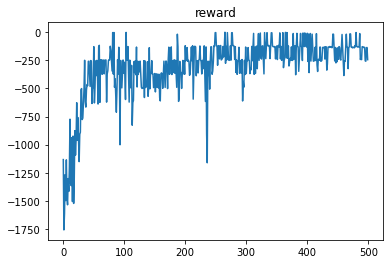

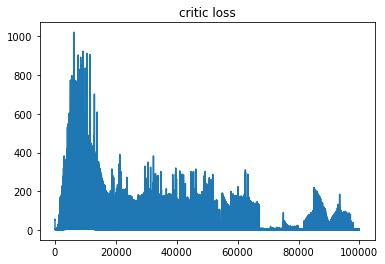

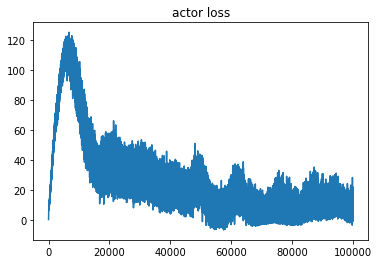

In [16]:
import matplotlib.pyplot as plt

plt.plot(rewards)
plt.title('reward')
plt.show()

plt.plot(critic_loss_traj)
plt.title('critic loss')
plt.show()

plt.plot(actor_loss_traj)
plt.title('actor loss')
plt.show()

## 학습 되었는지 확인하기 2
- 학습된 policy를 render 해보면서 잘 학습되었는지 확인해 봅시다!

In [17]:
state = env.reset()

while True:
    
    env.render()

    state_input = torch.tensor(state, dtype=torch.float32)
    
    _, action_norm = agent.get_action(state_input)

    state, _, done, _ = env.step(action_norm)

    if done:
        break

env.close()

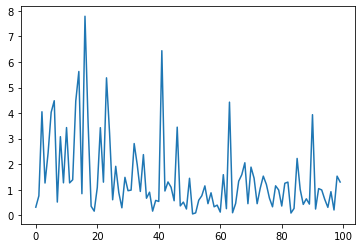

In [19]:
plt.plot(critic_loss_traj[-100:])

episode :    0, reward : -26.983, critic loss : 0.000, actor loss : 0.004
episode :    1, reward : -28.411, critic loss : 0.000, actor loss : 0.002
episode :    2, reward : -27.381, critic loss : 0.000, actor loss : 0.000
episode :    3, reward :  74.884, critic loss : 0.000, actor loss : -0.000
episode :    4, reward :  89.018, critic loss : 1.775, actor loss : -0.025
episode :    5, reward :  72.356, critic loss : 3.458, actor loss : -0.203
episode :    6, reward :  73.943, critic loss : 5.828, actor loss : -0.810
episode :    7, reward :  79.137, critic loss : 4.593, actor loss : -0.935
episode :    8, reward :  91.187, critic loss : 3.851, actor loss : -1.122
episode :    9, reward :  87.488, critic loss : 4.846, actor loss : -1.326
episode :   10, reward :  93.443, critic loss : 4.306, actor loss : -1.616
episode :   11, reward : -49.487, critic loss : 1.865, actor loss : -2.128
episode :   12, reward :  77.340, critic loss : 0.388, actor loss : -2.415
episode :   13, reward :  86

episode :  109, reward :  95.331, critic loss : 1.727, actor loss : -80.063
episode :  110, reward :  94.775, critic loss : 1.772, actor loss : -80.043
episode :  111, reward :  93.911, critic loss : 1.854, actor loss : -79.843
episode :  112, reward :  93.861, critic loss : 1.726, actor loss : -80.042
episode :  113, reward :  93.543, critic loss : 1.803, actor loss : -79.668
episode :  114, reward :  94.218, critic loss : 1.739, actor loss : -79.326
episode :  115, reward :  94.095, critic loss : 1.705, actor loss : -79.985
episode :  116, reward :  95.012, critic loss : 1.663, actor loss : -79.698
episode :  117, reward :  93.858, critic loss : 1.824, actor loss : -79.143
episode :  118, reward :  93.997, critic loss : 1.989, actor loss : -79.411
episode :  119, reward :  94.381, critic loss : 2.049, actor loss : -79.189
episode :  120, reward :  94.060, critic loss : 1.983, actor loss : -79.563
episode :  121, reward :  90.722, critic loss : 1.905, actor loss : -79.127
episode :  1

episode :  217, reward :  84.225, critic loss : 0.687, actor loss : -65.200
episode :  218, reward :  85.700, critic loss : 0.619, actor loss : -64.110
episode :  219, reward :  91.727, critic loss : 0.596, actor loss : -63.638
episode :  220, reward :  88.034, critic loss : 0.649, actor loss : -62.979
episode :  221, reward :  88.059, critic loss : 0.597, actor loss : -62.653
episode :  222, reward :  84.221, critic loss : 0.526, actor loss : -61.732
episode :  223, reward :  84.845, critic loss : 0.522, actor loss : -61.095
episode :  224, reward :  77.096, critic loss : 0.480, actor loss : -59.813
episode :  225, reward :  87.685, critic loss : 0.485, actor loss : -59.349
episode :  226, reward :  78.607, critic loss : 0.393, actor loss : -58.375
episode :  227, reward :  84.073, critic loss : 0.361, actor loss : -57.726
episode :  228, reward :  81.223, critic loss : 0.345, actor loss : -56.896
episode :  229, reward :  86.481, critic loss : 0.347, actor loss : -56.188
episode :  2

episode :  325, reward :  93.373, critic loss : 0.365, actor loss : -64.013
episode :  326, reward :  94.869, critic loss : 0.366, actor loss : -64.193
episode :  327, reward :  93.998, critic loss : 0.401, actor loss : -64.288
episode :  328, reward :  92.193, critic loss : 0.357, actor loss : -63.984
episode :  329, reward :  94.658, critic loss : 0.372, actor loss : -64.201
episode :  330, reward :  93.740, critic loss : 0.348, actor loss : -64.318
episode :  331, reward :  89.986, critic loss : 0.379, actor loss : -63.968
episode :  332, reward :  93.889, critic loss : 0.405, actor loss : -63.830
episode :  333, reward :  92.103, critic loss : 0.397, actor loss : -64.227
episode :  334, reward :  94.657, critic loss : 0.445, actor loss : -64.344
episode :  335, reward :  94.166, critic loss : 0.449, actor loss : -64.793
episode :  336, reward :  94.442, critic loss : 0.389, actor loss : -65.199
episode :  337, reward :  85.480, critic loss : 0.437, actor loss : -64.396
episode :  3

episode :  433, reward :  94.002, critic loss : 0.252, actor loss : -69.284
episode :  434, reward :  94.038, critic loss : 0.245, actor loss : -69.850
episode :  435, reward :  94.636, critic loss : 0.254, actor loss : -69.793
episode :  436, reward :  94.082, critic loss : 0.222, actor loss : -70.030
episode :  437, reward :  94.420, critic loss : 0.211, actor loss : -69.722
episode :  438, reward :  93.944, critic loss : 0.239, actor loss : -69.856
episode :  439, reward :  93.886, critic loss : 0.214, actor loss : -69.614
episode :  440, reward :  94.541, critic loss : 0.203, actor loss : -69.472
episode :  441, reward :  94.181, critic loss : 0.216, actor loss : -69.779
episode :  442, reward :  94.023, critic loss : 0.214, actor loss : -69.685
episode :  443, reward :  92.904, critic loss : 0.214, actor loss : -69.767
episode :  444, reward :  94.189, critic loss : 0.221, actor loss : -69.583
episode :  445, reward :  93.601, critic loss : 0.225, actor loss : -69.697
episode :  4

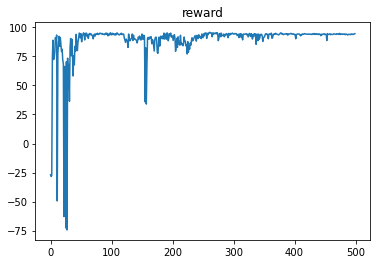

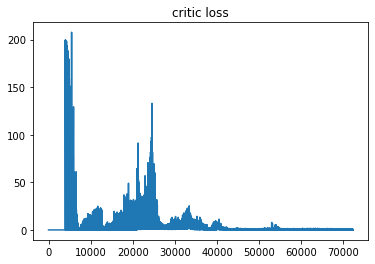

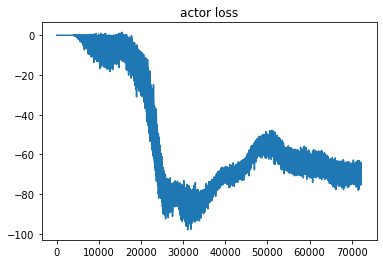

In [20]:
env_name = "MountainCarContinuous-v0"
env = gym.make(env_name)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

action_low = env.action_space.low
action_high = env.action_space.high

agent = DDPGAgent(state_dim, action_dim, action_low, action_high)

# 환경 변수
MAX_EPISODES = 500

# Performance metric
rewards = []
critic_loss_traj = []
actor_loss_traj = []

for e in range(MAX_EPISODES):

    state = env.reset()
    episode_reward = 0
    step = 0
    critic_loss_epi = []
    actor_loss_epi = []

    while True:

        state = torch.tensor(state, dtype=torch.float32)
        action, action_norm = agent.get_action(state, step)

        next_state, reward, done, info = env.step(action_norm)

        transition = [state, action, reward, next_state, done]
        
        agent.push(transition) # 매 step마다 transition을 저장해주기

        state = next_state
        episode_reward += reward

        if agent.train_start():
            critic_loss, actor_loss = agent.fit()
            
            critic_loss_epi.append(critic_loss)
            actor_loss_epi.append(actor_loss)
            
        if done:
            rewards.append(episode_reward)
            critic_loss_traj += critic_loss_epi
            actor_loss_traj += actor_loss_epi
            
            critic_mean = sum(critic_loss_epi) / len(critic_loss_epi)
            actor_mean = sum(actor_loss_epi) / len(actor_loss_epi)
            
            print("episode : %4d, reward : % 4.3f, critic loss : %4.3f, actor loss : %4.3f" % (e, rewards[-1], critic_mean, actor_mean))
            break

        step += 1
        
import matplotlib.pyplot as plt

plt.plot(rewards)
plt.title('reward')
plt.show()

plt.plot(critic_loss_traj)
plt.title('critic loss')
plt.show()

plt.plot(actor_loss_traj)
plt.title('actor loss')
plt.show()

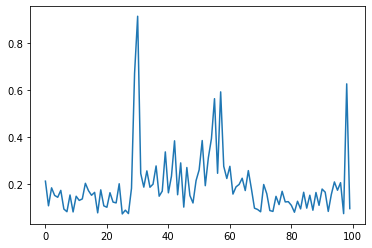

In [21]:
plt.plot(critic_loss_traj[-100:])

In [24]:
env_name = "CartPole-v1"
env = gym.make(env_name)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

action_low = env.action_space.low
action_high = env.action_space.high

agent = DDPGAgent(state_dim, action_dim, action_low, action_high)

# 환경 변수
MAX_EPISODES = 500

# Performance metric
rewards = []
critic_loss_traj = []
actor_loss_traj = []

for e in range(MAX_EPISODES):

    state = env.reset()
    episode_reward = 0
    step = 0
    critic_loss_epi = []
    actor_loss_epi = []

    while True:

        state = torch.tensor(state, dtype=torch.float32)
        action, action_norm = agent.get_action(state, step)

        next_state, reward, done, info = env.step(action_norm)

        transition = [state, action, reward, next_state, done]
        
        agent.push(transition) # 매 step마다 transition을 저장해주기

        state = next_state
        episode_reward += reward

        if agent.train_start():
            critic_loss, actor_loss = agent.fit()
            
            critic_loss_epi.append(critic_loss)
            actor_loss_epi.append(actor_loss)
            
        if done:
            rewards.append(episode_reward)
            critic_loss_traj += critic_loss_epi
            actor_loss_traj += actor_loss_epi
            
            critic_mean = sum(critic_loss_epi) / len(critic_loss_epi)
            actor_mean = sum(actor_loss_epi) / len(actor_loss_epi)
            
            print("episode : %4d, reward : % 4.3f, critic loss : %4.3f, actor loss : %4.3f" % (e, rewards[-1], critic_mean, actor_mean))
            break

        step += 1
        
import matplotlib.pyplot as plt

plt.plot(rewards)
plt.title('reward')
plt.show()

plt.plot(critic_loss_traj)
plt.title('critic loss')
plt.show()

plt.plot(actor_loss_traj)
plt.title('actor loss')
plt.show()

IndexError: tuple index out of range

In [25]:
env.action_space

Discrete(2)